*Author:*  
**Ella Pournezhad**  
  
*Description:*   
**Air Pollution Data is being cleansed, processed and analysed in this code.**  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Functions Defining:

In [2]:
# Define custom aggregation functions
def custom_mean(x):
    return x.mean()

def custom_min(x):
    return x.min()

def custom_max(x):
    return x.max()

In [3]:
def drop_status_column(df):
    for column in df.columns:
        if column.startswith('Status'):
            df.drop(columns=[column], inplace=True)

In [4]:
def merge_dataframes(dataframes):
    '''This function merges multiple dataframes'''
    merged_df = pd.concat(dataframes, ignore_index=True, sort=False)
    return merged_df

In [5]:
def add_station_name(df, file_name):
    ''' This function extracts station name from file name and adds it in StationName column'''
    station_name = file_name.split('/')[-1].split(' ')[1:-1]  # Extracting words between first and last in file name
    station_name = ' '.join(station_name)
    station_name = station_name.replace("'", "")
    df.insert(2, "StationName", station_name)

In [6]:
def read_and_add_station_name(file_path):
    df = pd.read_csv(file_path)
    add_station_name(df, file_path)
    return df

In [7]:
def convert_to_float(df, columns):
    for column in columns:
        df[column] = df[column].astype(float)

In [8]:
def remove_rows_with_negative_values(df, pollutant_columns):
    ''' This function removes rows with negative value for one pollutant.'''
    mask = df[pollutant_columns] < 0
    rows_with_negative_values = mask.any(axis=1)
    df_cleaned = df[~rows_with_negative_values]
    return df_cleaned

In [9]:
def fill_missing_months(df):
    ''' This functions adds monthly records with Nan values for the missing months in dataset.'''
    date_column_label = df.columns[0][0]  # Assuming the Date column is the first level of the multi-level index
    
    # Creating a DataFrame with complete date range
    start_date = df[(date_column_label,)].min().replace(month=1)
    end_date = df[(date_column_label,)].max()
    complete_date_range = pd.date_range(start=start_date, end=end_date, freq='M' )
    complete_df = pd.DataFrame({(date_column_label, ''): complete_date_range})
    complete_df[(date_column_label, '')] = complete_df[(date_column_label, '')] + pd.offsets.MonthBegin(1)

    # Merging with existing DataFrame
    merged_df = pd.merge(complete_df, df, on=date_column_label, how='left')

    
    return merged_df

In [10]:
def split_dataframe_by_date(df, date_column, split_date, end_date ='2024-01-01'):
    """ This function splits a DataFrame into two based on a given value for a date column."""
    df[date_column] = pd.to_datetime(df[date_column])  # Convert to datetime if not already
    df_before = df[df[date_column] < split_date]
    df_after = df[(df[date_column] >= split_date) & (df[date_column] <= end_date)]
 
    df_before.reset_index(drop=True, inplace=True)
    df_after.reset_index(drop=True, inplace=True)
       
    return df_before, df_after

### Loading Data Files:

In the original data files downloaded from the site (????? site must be added ?????)  
there were some extra rows **outside the table** which were removed manually.

In [11]:
df1_path = "AP data - changed/Bristol Centre 2004-2006.csv"
df2_path = "AP data - changed/Bristol Temple Way 2018-2024.csv"
df3_path = "AP data - changed/Bristol Old Market 2004-2013.csv"
df4_path = "AP data - changed/Bristol St Paul's 2007-2024.csv"

In [12]:
# Loading data and adding StationName to each dataframe
df1 = read_and_add_station_name(df1_path)
df2 = read_and_add_station_name(df2_path)
df3 = read_and_add_station_name(df3_path)
df4 = read_and_add_station_name(df4_path)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6012\3136336549.py:2: DtypeWarning: Columns (17,19,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


### Preprocessing Data:

In [13]:
# Dropping 'Status' columns if they exist
drop_status_column(df1)
drop_status_column(df2)
drop_status_column(df3)
drop_status_column(df4)

df1.info()  
df2.info()  
df3.info()  
df4.info()  

In [14]:
# Merging dataframes
merged_df = merge_dataframes([df1, df2, df3, df4])

In [15]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293478 entries, 0 to 293477
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype 
---  ------                                      --------------   ----- 
 0   Date                                        293475 non-null  object
 1   Time                                        293474 non-null  object
 2   StationName                                 293478 non-null  object
 3   Ozone                                       163992 non-null  object
 4   Nitric oxide                                293474 non-null  object
 5   Nitrogen dioxide                            293474 non-null  object
 6   Nitrogen oxides as nitrogen dioxide         293474 non-null  object
 7   Sulphur dioxide                             163992 non-null  object
 8   Carbon monoxide                             239976 non-null  object
 9   PM10 particulate matter (Hourly measured)   217490 non-null  object
 10  Modelled

In [16]:
# importing into CSV
merged_df.to_csv('AP data - merged.csv' , index= False)

### Data Cleansing:

In [17]:
df_clean = merged_df

In [18]:
# Changing 'No data' values into valid NaN
df_clean = df_clean.replace('No data	', np.NaN)
df_clean = df_clean.replace('No data', np.NaN)

In [19]:
# Sorting Data
df_clean = df_clean.sort_values(by=['Date', 'Time', 'StationName'])
df_clean = df_clean.reset_index(drop=True)

In [20]:
# Converting Date column into valid datetime type
df_clean['Date2'] = pd.to_datetime(df_clean['Date'], format='%m/%d/%Y', errors='coerce')

In [21]:
# Removing rows with invalid dates
df_clean['Date'] = df_clean['Date2']
df_clean = df_clean.dropna(subset=['Date'])
df_clean.drop(columns=['Date2'], inplace= True)

In [22]:
# Defining list of pollutant columns and wind columns and all columns

all_columns = ['Ozone', 'Nitric oxide', 'Nitrogen dioxide', 
                 'Nitrogen oxides as nitrogen dioxide', 
                 'Sulphur dioxide', 'Carbon monoxide', 
                 'PM10 particulate matter (Hourly measured)',
                 'Modelled Wind Direction', 'Modelled Wind Speed',
                 'Modelled Temperature',
                 'Non-volatile PM10 (Hourly measured)',
                 'Volatile PM10 (Hourly measured)',
                 'PM2.5 particulate matter (Hourly measured)',
                 'Non-volatile PM2.5 (Hourly measured)',
                 'Volatile PM2.5 (Hourly measured)']

pollutants = ['Ozone', 'Nitric oxide', 'Nitrogen dioxide', 
                 'Nitrogen oxides as nitrogen dioxide', 
                 'Sulphur dioxide', 'Carbon monoxide', 
                 'PM10 particulate matter (Hourly measured)',
                 'Non-volatile PM10 (Hourly measured)',
                 'Volatile PM10 (Hourly measured)',
                 'PM2.5 particulate matter (Hourly measured)',
                 'Non-volatile PM2.5 (Hourly measured)',
                 'Volatile PM2.5 (Hourly measured)'] #12

Nitrogen_pollutants = ['Nitric oxide', 'Nitrogen dioxide', 'Nitrogen oxides as nitrogen dioxide']

PM_pollutants = ['PM10 particulate matter (Hourly measured)',
                 'Non-volatile PM10 (Hourly measured)',
                 'Volatile PM10 (Hourly measured)',
                 'PM2.5 particulate matter (Hourly measured)',
                 'Non-volatile PM2.5 (Hourly measured)',
                 'Volatile PM2.5 (Hourly measured)']

Other_pollutants = ['Ozone', 'Sulphur dioxide', 'Carbon monoxide']

Winds = ['Modelled Wind Direction', 'Modelled Wind Speed', 'Modelled Temperature']

In [23]:
stations = df_clean['StationName'].unique()

In [24]:
# Changing Datatypes
convert_to_float(df_clean, all_columns)

In [25]:
# Removing rows with negative value pollutants
df_clean = remove_rows_with_negative_values(df_clean, pollutants)

In [26]:
df_clean.describe()

,Date,Ozone,Nitric oxide,Nitrogen dioxide,Nitrogen oxides as nitrogen dioxide,Sulphur dioxide,Carbon monoxide,PM10 particulate matter (Hourly measured),Modelled Wind Direction,Modelled Wind Speed,Modelled Temperature,Non-volatile PM10 (Hourly measured),Volatile PM10 (Hourly measured),PM2.5 particulate matter (Hourly measured),Non-volatile PM2.5 (Hourly measured),Volatile PM2.5 (Hourly measured)
count,279761,143480.000000,270238.000000,263035.000000,263034.000000,58468.000000,120875.000000,187617.000000,46969.000000,46969.000000,46969.000000,86821.000000,86814.000000,106864.000000,72542.000000,72542.000000
mean,2014-01-28 05:35:47.471591680,44.321060,30.235513,36.825850,81.231178,2.419751,0.422890,19.160492,195.661675,4.795753,9.674556,15.284098,3.602358,12.038296,9.951749,3.629247
min,2004-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2008-09-28 00:00:00,26.000000,2.272295,15.045235,19.408898,0.000000,0.200000,10.700000,124.100000,2.900000,6.000000,8.000000,1.600000,5.600000,4.000000,2.000000
50%,2013-01-24 00:00:00,46.000000,7.000000,29.000000,40.000000,3.000000,0.300000,16.000000,217.000000,4.300000,9.500000,12.300000,3.000000,8.800000,7.000000,3.000000
75%,2020-01-08 00:00:00,62.000000,33.000000,51.757450,98.375655,3.000000,0.500000,24.000000,268.300000,6.200000,13.400000,19.000000,5.000000,14.600000,12.100000,4.700000
max,2024-02-08 00:00:00,178.216010,888.000000,288.000000,1645.000000,82.000000,6.300000,481.000000,360.000000,19.000000,29.700000,465.000000,29.000000,320.000000,311.000000,26.000000
std,NaN,25.259977,54.140073,28.130900,104.704643,3.285349,0.368914,13.288959,90.564160,2.655042,5.322904,12.591567,3.011835,11.419159,10.404207,2.853946


In [27]:
df_clean.head(5)

,Date,Time,StationName,Ozone,Nitric oxide,Nitrogen dioxide,Nitrogen oxides as nitrogen dioxide,Sulphur dioxide,Carbon monoxide,PM10 particulate matter (Hourly measured),Modelled Wind Direction,Modelled Wind Speed,Modelled Temperature,Non-volatile PM10 (Hourly measured),Volatile PM10 (Hourly measured),PM2.5 particulate matter (Hourly measured),Non-volatile PM2.5 (Hourly measured),Volatile PM2.5 (Hourly measured)
0,2004-01-01,10:00:00,Centre,58.0,3.0,15.0,19.0,0.0,0.1,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-01-01,10:00:00,Old Market,NaN,1.0,21.0,23.0,NaN,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004-01-01,11:00:00,Centre,60.0,3.0,19.0,23.0,3.0,0.1,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004-01-01,11:00:00,Old Market,NaN,1.0,25.0,27.0,NaN,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004-01-01,12:00:00,Centre,64.0,4.0,15.0,21.0,3.0,0.1,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df_clean.groupby(['StationName']).mean([Nitrogen_pollutants])

,Ozone,Nitric oxide,Nitrogen dioxide,Nitrogen oxides as nitrogen dioxide,Sulphur dioxide,Carbon monoxide,PM10 particulate matter (Hourly measured),Modelled Wind Direction,Modelled Wind Speed,Modelled Temperature,Non-volatile PM10 (Hourly measured),Volatile PM10 (Hourly measured),PM2.5 particulate matter (Hourly measured),Non-volatile PM2.5 (Hourly measured),Volatile PM2.5 (Hourly measured)
StationName,,,,,,,,,,,,,,,
Centre,42.372550,26.549752,34.471985,74.881590,3.645702,0.371641,24.160275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Old Market,NaN,66.104516,60.819489,160.575632,NaN,0.492212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
St Pauls,44.532293,12.512635,25.877445,45.003702,2.022465,0.340786,18.275859,NaN,NaN,NaN,15.284098,3.602358,12.038296,9.951749,3.629247
Temple Way,NaN,23.572978,33.393485,69.537897,NaN,NaN,19.917743,195.661675,4.795753,9.674556,NaN,NaN,NaN,NaN,NaN


### Data Synchronize

To calculate the correlation between hourly time series data and monthly data, we need to synchronize them properly. Here are a few approaches to consider:  

<b> </b>  
**Resampling**: Resample hourly data to monthly frequency. This involves aggregating the hourly data into monthly intervals by taking the mean, sum, or another aggregation function.   

<b> </b>  
**Rolling Window Aggregation**: Instead of resampling, calculate rolling window statistics (e.g., mean, sum) over monthly intervals for hourly data. This approach gives more flexibility in capturing short-term variations within each month.  

<b> </b>     
**Interpolation**: If hourly data is dense enough, interpolating it to fill in missing values and then aggregate to monthly frequency. This might be useful ifneed to preserve the original granularity of hourly data.  

<b> </b>   
**Aligning Timestamps**: Align the timestamps of hourly data with the timestamps of monthly data. Then, aggregate the hourly data within each month (e.g., take the mean) to match the monthly frequency.  

<b> </b>  
  

In [29]:
# Resampling air pollution data to monthly frequency for all stations

monthly_air_pollution = df_clean.groupby([pd.Grouper(key='Date', freq='M')]).agg({
    'Ozone': ['mean', 'min', 'max'],
    'Nitric oxide': ['mean', 'min', 'max'],
    'Nitrogen dioxide': ['mean', 'min', 'max'],
    'Nitrogen oxides as nitrogen dioxide': ['mean', 'min', 'max'],
    'Sulphur dioxide': ['mean', 'min', 'max'],
    'Carbon monoxide': ['mean', 'min', 'max'],
    'PM10 particulate matter (Hourly measured)': ['mean', 'min', 'max'],
    'Non-volatile PM10 (Hourly measured)' : ['mean', 'min', 'max'],
    'Volatile PM10 (Hourly measured)': ['mean', 'min', 'max'],
    'PM2.5 particulate matter (Hourly measured)': ['mean', 'min', 'max'],
    'Non-volatile PM2.5 (Hourly measured)': ['mean', 'min', 'max'],
    'Volatile PM2.5 (Hourly measured)': ['mean', 'min', 'max'],
    'Modelled Wind Direction': ['mean', 'min', 'max'], 
    'Modelled Wind Speed': ['mean', 'min', 'max'],
    'Modelled Temperature': ['mean', 'min', 'max']
})

monthly_air_pollution.reset_index(inplace=True)
monthly_air_pollution['Date'] = monthly_air_pollution['Date'] + pd.offsets.MonthBegin(1)

In [30]:
monthly_air_pollution

Date      Ozone                     Nitric oxide           \
                     mean      min        max         mean      min   
0   2004-02-01  40.588045  2.00000   88.00000    38.840278  0.00000   
1   2004-03-01  37.623053  2.00000   86.00000    43.377152  0.00000   
2   2004-04-01  44.042042  0.00000   94.00000    49.629445  0.00000   
3   2004-05-01  53.327217  2.00000  120.00000    31.011963  0.00000   
4   2004-06-01  48.181556  2.00000  100.00000    33.709743  0.00000   
..         ...        ...      ...        ...          ...      ...   
237 2023-11-01  39.759727  1.29721   88.16005    11.096945  0.06547   
238 2023-12-01  42.407416  0.79828   81.87359    16.830495  0.09991   
239 2024-01-01  48.790267  1.29721   85.74858    12.378710  0.00000   
240 2024-02-01        NaN      NaN        NaN    27.772395  0.12473   
241 2024-03-01        NaN      NaN        NaN     8.006932  0.00000   

               Nitrogen dioxide                      ...  \
           max             mean      min        max  ...   
0    380.00000        45.001389  4.00000  162.00000  ...   
1    606.00000        51.432707  4.00000  176.00000  ...   
2    465.00000        55.866287  0.00000  181.00000  ...   
3    310.00000        42.304715  0.00000  147.00000  ...   
4    298.00000        47.074425  6.00000  162.00000  ...   
..         ...              ...      ...        ...  ...   
237  129.38851        22.749615  1.75219   64.05096  ...   
238  218.24185        23.792764  0.26643   76.18815  ...   
239  292.22351        20.647389  0.00896   76.55475  ...   
240  343.01623        32.355190  1.14559   76.35656  ...   
241   91.67655        17.316000  1.33875   66.74625  ...   

    Volatile PM2.5 (Hourly measured) Modelled Wind Direction               \
                                 max                    mean   min    max   
0                                NaN                     NaN   NaN    NaN   
1                                NaN                     NaN   NaN    NaN   
2                                NaN                     NaN   NaN    NaN   
3                                NaN                     NaN   NaN    NaN   
4                                NaN                     NaN   NaN    NaN   
..                               ...                     ...   ...    ...   
237                              NaN              194.141272   0.7  359.3   
238                              NaN              224.572500   0.1  359.5   
239                              NaN              224.633063   0.5  359.6   
240                              NaN              193.153898   0.3  359.4   
241                              NaN              234.922024  35.9  355.8   

    Modelled Wind Speed            Modelled Temperature             
                   mean  min   max                 mean  min   max  
0                   NaN  NaN   NaN                  NaN  NaN   NaN  
1                   NaN  NaN   NaN                  NaN  NaN   NaN  
2                   NaN  NaN   NaN                  NaN  NaN   NaN  
3                   NaN  NaN   NaN                  NaN  NaN   NaN  
4                   NaN  NaN   NaN                  NaN  NaN   NaN  
..                  ...  ...   ...                  ...  ...   ...  
237            4.681326  0.2  12.7            11.571313  3.1  21.0  
238            5.519306  0.0  15.7             7.421111 -1.8  13.6  
239            6.668556  0.0  14.7             6.754251 -3.7  12.1  
240            5.539516  0.1  17.9             3.698522 -5.0  12.2  
241            7.223810  1.0  11.2             7.695238  2.1  11.0  

[242 rows x 46 columns]

**Adding Nan records for missing months.**

In [31]:
monthly_air_pollution = fill_missing_months(monthly_air_pollution)
monthly_air_pollution.reset_index(drop=True, inplace=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6012\3488813691.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  start_date = df[(date_column_label,)].min().replace(month=1)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_6012\3488813691.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  end_date = df[(date_column_label,)].max()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_6012\3488813691.py:13: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_df = pd.merge(complete_df, df, on=date_column_label, how='left')


In [32]:
monthly_air_pollution

Date      Ozone                     Nitric oxide           \
                     mean      min        max         mean      min   
0   2004-02-01  40.588045  2.00000   88.00000    38.840278  0.00000   
1   2004-03-01  37.623053  2.00000   86.00000    43.377152  0.00000   
2   2004-04-01  44.042042  0.00000   94.00000    49.629445  0.00000   
3   2004-05-01  53.327217  2.00000  120.00000    31.011963  0.00000   
4   2004-06-01  48.181556  2.00000  100.00000    33.709743  0.00000   
..         ...        ...      ...        ...          ...      ...   
237 2023-11-01  39.759727  1.29721   88.16005    11.096945  0.06547   
238 2023-12-01  42.407416  0.79828   81.87359    16.830495  0.09991   
239 2024-01-01  48.790267  1.29721   85.74858    12.378710  0.00000   
240 2024-02-01        NaN      NaN        NaN    27.772395  0.12473   
241 2024-03-01        NaN      NaN        NaN     8.006932  0.00000   

               Nitrogen dioxide                      ...  \
           max             mean      min        max  ...   
0    380.00000        45.001389  4.00000  162.00000  ...   
1    606.00000        51.432707  4.00000  176.00000  ...   
2    465.00000        55.866287  0.00000  181.00000  ...   
3    310.00000        42.304715  0.00000  147.00000  ...   
4    298.00000        47.074425  6.00000  162.00000  ...   
..         ...              ...      ...        ...  ...   
237  129.38851        22.749615  1.75219   64.05096  ...   
238  218.24185        23.792764  0.26643   76.18815  ...   
239  292.22351        20.647389  0.00896   76.55475  ...   
240  343.01623        32.355190  1.14559   76.35656  ...   
241   91.67655        17.316000  1.33875   66.74625  ...   

    Volatile PM2.5 (Hourly measured) Modelled Wind Direction               \
                                 max                    mean   min    max   
0                                NaN                     NaN   NaN    NaN   
1                                NaN                     NaN   NaN    NaN   
2                                NaN                     NaN   NaN    NaN   
3                                NaN                     NaN   NaN    NaN   
4                                NaN                     NaN   NaN    NaN   
..                               ...                     ...   ...    ...   
237                              NaN              194.141272   0.7  359.3   
238                              NaN              224.572500   0.1  359.5   
239                              NaN              224.633063   0.5  359.6   
240                              NaN              193.153898   0.3  359.4   
241                              NaN              234.922024  35.9  355.8   

    Modelled Wind Speed            Modelled Temperature             
                   mean  min   max                 mean  min   max  
0                   NaN  NaN   NaN                  NaN  NaN   NaN  
1                   NaN  NaN   NaN                  NaN  NaN   NaN  
2                   NaN  NaN   NaN                  NaN  NaN   NaN  
3                   NaN  NaN   NaN                  NaN  NaN   NaN  
4                   NaN  NaN   NaN                  NaN  NaN   NaN  
..                  ...  ...   ...                  ...  ...   ...  
237            4.681326  0.2  12.7            11.571313  3.1  21.0  
238            5.519306  0.0  15.7             7.421111 -1.8  13.6  
239            6.668556  0.0  14.7             6.754251 -3.7  12.1  
240            5.539516  0.1  17.9             3.698522 -5.0  12.2  
241            7.223810  1.0  11.2             7.695238  2.1  11.0  

[242 rows x 46 columns]

### Data cropping

Here we split the dataset into the records before April 2016 and after April 2016, because our Health data starts from  April 2016.

In [33]:
# Spliting data into df_before and df_after
date_column = 'Date'
split_date = '2015-06-01' # min date in Health data

df_before, df_after = split_dataframe_by_date(monthly_air_pollution, date_column, split_date)

In [34]:
df_before

Date      Ozone                     Nitric oxide           \
                     mean      min        max         mean      min   
0   2004-02-01  40.588045  2.00000   88.00000    38.840278  0.00000   
1   2004-03-01  37.623053  2.00000   86.00000    43.377152  0.00000   
2   2004-04-01  44.042042  0.00000   94.00000    49.629445  0.00000   
3   2004-05-01  53.327217  2.00000  120.00000    31.011963  0.00000   
4   2004-06-01  48.181556  2.00000  100.00000    33.709743  0.00000   
..         ...        ...      ...        ...          ...      ...   
131 2015-01-01  33.056885  2.34495   80.12735    38.620429  0.22982   
132 2015-02-01  44.432911  2.64430   85.16650    11.759468  0.06237   
133 2015-03-01  36.555998  2.92703   81.42456    18.458090  0.21828   
134 2015-04-01  45.904294  3.04344   87.31188     9.572751  0.23699   
135 2015-05-01  53.397357  0.99785  101.68092     6.372832  0.16683   

               Nitrogen dioxide                      ...  \
           max             mean      min        max  ...   
0    380.00000        45.001389  4.00000  162.00000  ...   
1    606.00000        51.432707  4.00000  176.00000  ...   
2    465.00000        55.866287  0.00000  181.00000  ...   
3    310.00000        42.304715  0.00000  147.00000  ...   
4    298.00000        47.074425  6.00000  162.00000  ...   
..         ...              ...      ...        ...  ...   
131  475.87894        39.762365  2.45613  144.03420  ...   
132  323.38591        30.528793  1.56953  154.87329  ...   
133  430.72387        41.843698  6.88181  121.96969  ...   
134  143.75631        30.203895  2.80277   84.21407  ...   
135  157.84457        21.007868  2.73233   67.50838  ...   

    Volatile PM2.5 (Hourly measured) Modelled Wind Direction          \
                                 max                    mean min max   
0                                NaN                     NaN NaN NaN   
1                                NaN                     NaN NaN NaN   
2                                NaN                     NaN NaN NaN   
3                                NaN                     NaN NaN NaN   
4                                NaN                     NaN NaN NaN   
..                               ...                     ...  ..  ..   
131                             12.0                     NaN NaN NaN   
132                             14.9                     NaN NaN NaN   
133                             16.5                     NaN NaN NaN   
134                             21.4                     NaN NaN NaN   
135                             22.0                     NaN NaN NaN   

    Modelled Wind Speed         Modelled Temperature          
                   mean min max                 mean min max  
0                   NaN NaN NaN                  NaN NaN NaN  
1                   NaN NaN NaN                  NaN NaN NaN  
2                   NaN NaN NaN                  NaN NaN NaN  
3                   NaN NaN NaN                  NaN NaN NaN  
4                   NaN NaN NaN                  NaN NaN NaN  
..                  ...  ..  ..                  ...  ..  ..  
131                 NaN NaN NaN                  NaN NaN NaN  
132                 NaN NaN NaN                  NaN NaN NaN  
133                 NaN NaN NaN                  NaN NaN NaN  
134                 NaN NaN NaN                  NaN NaN NaN  
135                 NaN NaN NaN                  NaN NaN NaN  

[136 rows x 46 columns]

In [35]:
df_after

Date      Ozone                     Nitric oxide           \
                     mean      min        max         mean      min   
0   2015-06-01  57.600437  0.44903   96.69167     2.881438  0.23408   
1   2015-07-01  54.258891  1.29721  132.86373     3.758570  0.33303   
2   2015-08-01  45.790808  0.04989  117.44695     4.971742  0.27940   
3   2015-09-01  38.842182  0.34925  113.15619     7.644233  0.25039   
4   2015-10-01  37.442629  1.04774   92.15145    10.643539  0.21412   
..         ...        ...      ...        ...          ...      ...   
99  2023-09-01  49.326983  0.29936   92.80005     5.902583  0.00000   
100 2023-10-01  51.707487  1.26394  149.12868     8.566071  0.00000   
101 2023-11-01  39.759727  1.29721   88.16005    11.096945  0.06547   
102 2023-12-01  42.407416  0.79828   81.87359    16.830495  0.09991   
103 2024-01-01  48.790267  1.29721   85.74858    12.378710  0.00000   

               Nitrogen dioxide                     ...  \
           max             mean      min       max  ...   
0     49.08874        14.341146  2.59208  53.90238  ...   
1     31.60970        18.609667  3.29428  65.20908  ...   
2     83.18275        19.439237  2.37724  67.51444  ...   
3    160.00021        23.763397  2.11857  76.36039  ...   
4    195.30379        26.937149  3.62546  76.13376  ...   
..         ...              ...      ...       ...  ...   
99   137.97762        13.753142  0.37835  57.65769  ...   
100  187.28039        22.713426  0.15162  84.56053  ...   
101  129.38851        22.749615  1.75219  64.05096  ...   
102  218.24185        23.792764  0.26643  76.18815  ...   
103  292.22351        20.647389  0.00896  76.55475  ...   

    Volatile PM2.5 (Hourly measured) Modelled Wind Direction              \
                                 max                    mean  min    max   
0                                8.2                     NaN  NaN    NaN   
1                               14.7                     NaN  NaN    NaN   
2                                7.2                     NaN  NaN    NaN   
3                                9.1                     NaN  NaN    NaN   
4                               10.9                     NaN  NaN    NaN   
..                               ...                     ...  ...    ...   
99                               NaN              240.257104  2.7  356.9   
100                              NaN              180.489784  0.5  355.9   
101                              NaN              194.141272  0.7  359.3   
102                              NaN              224.572500  0.1  359.5   
103                              NaN              224.633063  0.5  359.6   

    Modelled Wind Speed            Modelled Temperature             
                   mean  min   max                 mean  min   max  
0                   NaN  NaN   NaN                  NaN  NaN   NaN  
1                   NaN  NaN   NaN                  NaN  NaN   NaN  
2                   NaN  NaN   NaN                  NaN  NaN   NaN  
3                   NaN  NaN   NaN                  NaN  NaN   NaN  
4                   NaN  NaN   NaN                  NaN  NaN   NaN  
..                  ...  ...   ...                  ...  ...   ...  
99             4.091530  0.1  10.4            15.172268  8.1  24.1  
100            3.947482  0.2  11.0            15.610791  6.8  26.7  
101            4.681326  0.2  12.7            11.571313  3.1  21.0  
102            5.519306  0.0  15.7             7.421111 -1.8  13.6  
103            6.668556  0.0  14.7             6.754251 -3.7  12.1  

[104 rows x 46 columns]

### Iterate and draw plots

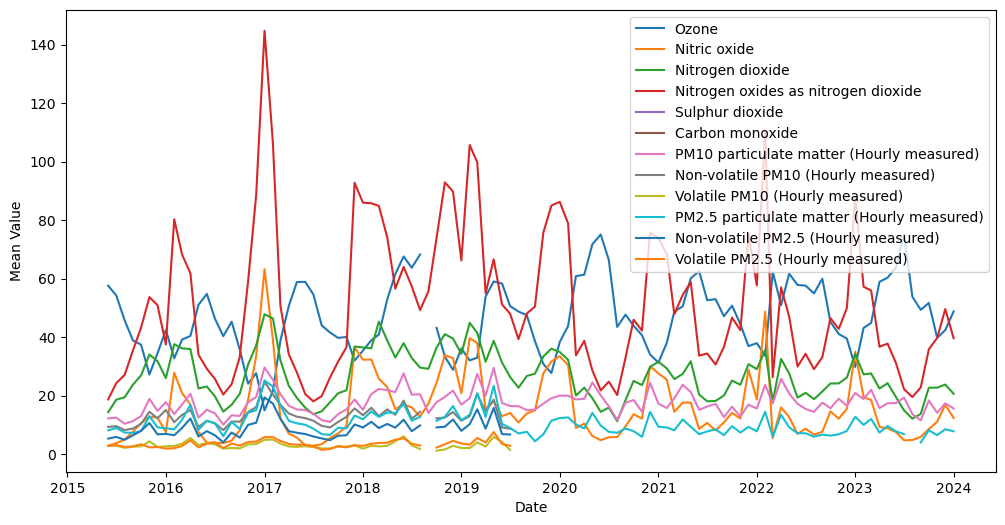

In [36]:
# Iterate over stations and create separate plots
plt.figure(figsize=(12, 6))
for pollutant in pollutants:
        plt.plot(df_after['Date'], 
             df_after[(pollutant, 'mean')], 
             label=pollutant)
    
    
plt.xlabel('Date')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

### Generatinf final file

In [37]:
df_after.to_csv('AP data - Final.csv', index=True)

In [38]:
df_after.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 46 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   (Date, )                                            104 non-null    datetime64[ns]
 1   (Ozone, mean)                                       103 non-null    float64       
 2   (Ozone, min)                                        103 non-null    float64       
 3   (Ozone, max)                                        103 non-null    float64       
 4   (Nitric oxide, mean)                                104 non-null    float64       
 5   (Nitric oxide, min)                                 104 non-null    float64       
 6   (Nitric oxide, max)                                 104 non-null    float64       
 7   (Nitrogen dioxide, mean)                            104 non-null    float64       
 8   (Nitrogen 

**File Generated**